## loading data

load normal data in an array

In [1]:
import os
import scipy.io
import numpy as np

raw_data = []

training_dir = os.path.join('..', 'data', 'training')
validation_dir = os.path.join('..', 'data', 'validation')

for Dir in [training_dir, validation_dir]:
    for Class in ['normal']:
        class_dir = os.path.join(Dir, Class)
        for file in [os.path.join(class_dir, _) for _ in os.listdir(class_dir) if _.endswith('.mat')]:
            mat_data = scipy.io.loadmat(file)
            sequence = mat_data['val'][0]
            normalised_sequence = (sequence - min(sequence)) / (max(sequence) - min(sequence))
            raw_data.append(normalised_sequence)

## pre-processing

transform data into 30s segments, remainders are tossed away.

take 800 random sequences, half of them add noise too the other half leave as is 

In [16]:
data = {'normal': [], 'noisy': []}
sampling_freq = 300

raw_data_sample = []
for i in raw_data:
    if len(i) >= sampling_freq * 30:
        raw_data_sample.append(i[:sampling_freq * 30])

idx = np.random.choice(len(raw_data_sample), size=800, replace=False)
raw_data_sample = np.array(raw_data_sample)[idx, :]

normal_data = raw_data_sample[:400]
noisy_data = []

def add_noise(x, std):
    f = np.random.normal(0.1, 0.1)
    a = np.random.normal(0.1, 0.03)
    l = np.random.randint(len(x))
    c = np.random.randint(len(x)-l)
    bw = a*np.sin(2*np.pi*f*np.arange(l)/sampling_freq)
    bw = np.pad(bw, (c, len(x)-l-c))
    
    high_freq = [0]*len(x)
    for i in range(100):
        f = (np.random.random_sample()*49)+1
        a = np.random.normal(0.2, 0.03)
        l = int(np.random.randint(len(x)*0.01))
        c = np.random.randint(len(x)-l)
        curr = a*np.sin(2*np.pi*f*np.arange(l)/sampling_freq)
        high_freq += np.pad(curr, (c, len(x)-l-c))
    
    l = int(np.random.randint(len(x)*0.4))
    c = np.random.randint(len(x)-l)
    sub = x
    sub[c:c+l] = np.mean(sub[c:c+l])
    
    awgn = np.random.normal(0, std, len(x))
    
    return sub+bw+high_freq+awgn

for i in raw_data_sample[400:]:
    noisy_data.append(add_noise(i, 0.005))

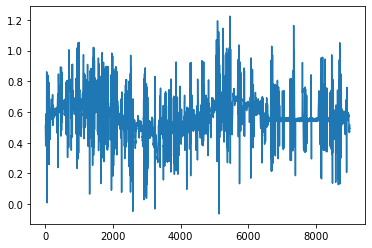

In [27]:
import matplotlib.pyplot as plt

plt.plot(noisy_data[9])

## pSQI

In [28]:
from scipy.signal import welch
from scipy.integrate import simps

def get_first_idx(x, a):
    for i in range(len(x)):
        if x[i] >= a:
            return i

def get_last_idx(x, a):
    for i in range(len(x)):
        if x[i] >= a:
            return i-1
        
psqi = {'normal': [], 'noisy': []}

for Class in ['normal', 'noisy']:
    curr = normal_data if Class=='normal' else noisy_data
    for i in curr:
        f, Pxx_den = welch(i, fs=150)
        u1 = simps(Pxx_den[get_first_idx(f, 5):get_last_idx(f, 15)], x=f[get_first_idx(f, 5):get_last_idx(f, 15)])
        u2 = simps(Pxx_den[get_first_idx(f, 5):get_last_idx(f, 40)], x=f[get_first_idx(f, 5):get_last_idx(f, 40)])
        psqi[Class].append(u1/u2)

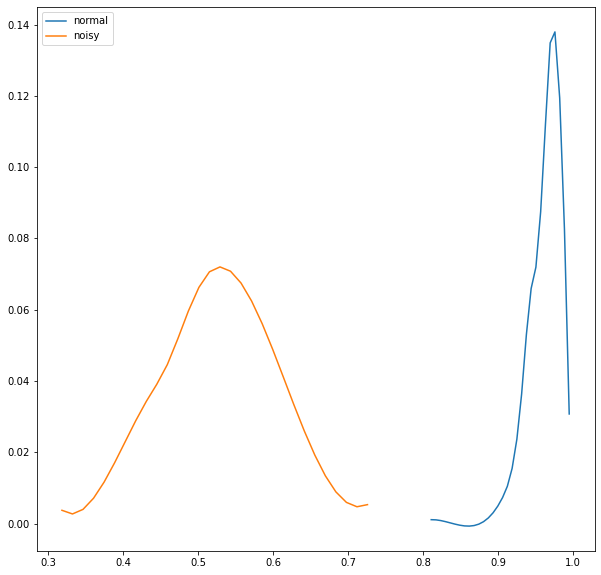

In [29]:
from scipy.interpolate import UnivariateSpline

fig, axs = plt.subplots(1, 1)
fig.set_size_inches(10, 10)


for Class in psqi.keys():
    psqi[Class] = np.array(psqi[Class])[~np.isnan(psqi[Class])]

    p, x = np.histogram(psqi[Class], bins=30)
    x = x[:-1] + (x[1] - x[0])/2
    f = UnivariateSpline(x, p, s=200)
    pdf = f(x) / len(psqi[Class])
    axs.plot(x, pdf, label=Class)

axs.legend()